# Disparity Estimation with Wavelet decomposition
This is a modified presentation of the result from the Wavelet_Decomposition_NYU git repository(linked below)

https://github.com/nianticlabs/wavelet-monodepth/blob/main/NYUv2/sparsity_test_notebook.ipynb

In [1]:
import os
import matplotlib.pyplot as plt
# %matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F

from pytorch_wavelets import IDWT

In [2]:
from networks.decoders import SparseDecoderWave, DecoderWave, Decoder
from networks.encoders import *

## Build Network

In [3]:
class DenseModel(nn.Module):
    def __init__(self, opts):
        super(DenseModel, self).__init__()
        
        decoder_width = 0.5
        self.encoder = DenseEncoder(normalize_input=opts.normalize_input, pretrained=opts.pretrained_encoder)                
        self.decoder = DecoderWave(enc_features=self.encoder.num_ch_enc, decoder_width=decoder_width)        

    def forward(self, x):
        return self.decoder( self.encoder(x) )
    
class Options(object):
    def __init__(self):
        super(Options, self).__init__()  
        
opts = Options()
opts.encoder_type = "densenet"
opts.output_scales =  [0, 1, 2, 3]  
opts.normalize_input = True
opts.use_wavelets = True      
opts.pretrained_encoder = False

models = {}
model = DenseModel(opts)

In [4]:
models_to_load = ["model"]

def load_model(model, load_weights_folder):
    """Load model(s) from disk
    """
    load_weights_folder = os.path.expanduser(load_weights_folder)
    print("loading weights from", load_weights_folder, "...")
    assert os.path.isdir(load_weights_folder), \
        "Cannot find folder {}".format(load_weights_folder)
    print("loading model from folder {}".format(load_weights_folder))    

    n = "model"
    print("Loading {} weights...".format(n))
    path = os.path.join(load_weights_folder, "{}.pth".format(n))
    model_dict = model.state_dict()
    pretrained_dict = torch.load(path, map_location={"cuda:0": "cpu"})
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)    

In [5]:
model_path = "./log/WaveletMDP/models/weights_9"
load_model(model, model_path)
model.eval()
print("Done")

loading weights from ./log/WaveletMDP/models/weights_9 ...
loading model from folder ./log/WaveletMDP/models/weights_9
Loading model weights...
Done


## Data loading

In [8]:
import scipy.io as io
import h5py
import os

from PIL import Image
from data import ToTensor
import numpy as np

nyu_root = "data"
nyu_dataset = h5py.File(os.path.join(nyu_root, "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)
splits_idx = io.loadmat(os.path.join(nyu_root, "nyuv2_splits.mat"))["testNdxs"]

def idx2nyu(idx):
    return int(splits_idx[idx])-1

In [9]:
to_tensor = ToTensor()

### Output of the after training with 10 epochs and partial dataset

(480, 640, 3) (480, 640)


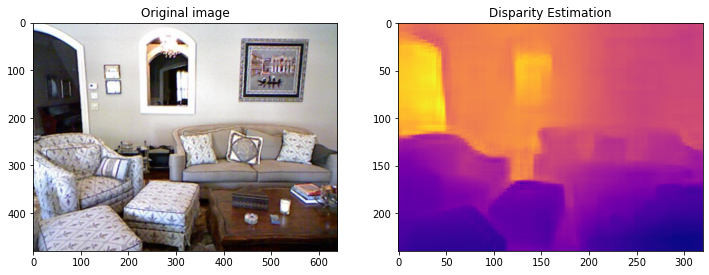

In [11]:
idx = 600
img = nyu_dataset["images"][idx2nyu(idx)].transpose(2,1,0)
depth = nyu_dataset["depths"][idx2nyu(idx)].transpose(1,0)
print(img.shape, depth.shape)

sample = {"image": Image.fromarray(img), "depth": Image.fromarray((depth*255/10000).astype('int32'))}
sample = to_tensor(sample)
img_tensor = sample["image"].unsqueeze(0)
thresh_ratio = 0.04
with torch.no_grad():
    outputs = model(img_tensor)            
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img_tensor[0].permute(1,2,0))

plt.subplot(1,2,2)
plt.title('Disparity Estimation')
plt.imshow(outputs[("disp", 0)][0,0], cmap="plasma")


### Output of 20 epochs trained with the entire dataset with depth data assistant

In [12]:
model_path = "./log/WaveletMDP/models/last"
load_model(model, model_path)
model.eval()
print("Done")

loading weights from ./log/WaveletMDP/models/last ...
loading model from folder ./log/WaveletMDP/models/last
Loading model weights...
Done


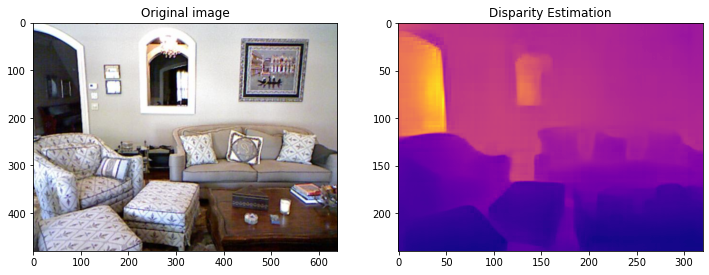

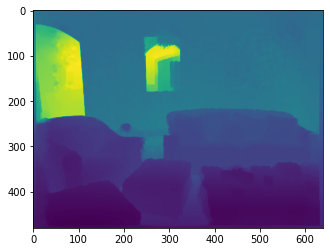

In [28]:
idx = 600
img = nyu_dataset["images"][idx2nyu(idx)].transpose(2,1,0)
depth = nyu_dataset["depths"][idx2nyu(idx)].transpose(1,0)

sample = {"image": Image.fromarray(img), "depth": Image.fromarray((depth*255/10000).astype('int32'))}
sample = to_tensor(sample)
img_tensor = sample["image"].unsqueeze(0)
thresh_ratio = 0.04
with torch.no_grad():
    outputs = model(img_tensor)            
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img_tensor[0].permute(1,2,0))

plt.subplot(1,2,2)
plt.title('Disparity Estimation')
plt.imshow(outputs[("disp", 0)][0,0], cmap="plasma")

plt.figure()
plt.imshow(depth*255/1000)

### Output of 20 epochs trained with the entire dataset without depth data assistant

<PIL.Image.Image image mode=I size=640x480 at 0x132DF436D30>


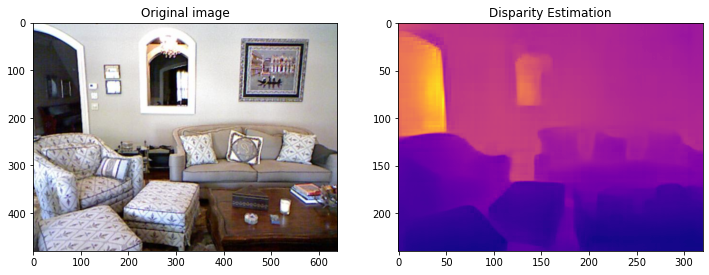

In [31]:
idx = 600
img = nyu_dataset["images"][idx2nyu(idx)].transpose(2,1,0)
depth = nyu_dataset["depths"][idx2nyu(idx)].transpose(1,0)

sample = {"image": Image.fromarray(img), "depth": Image.fromarray((depth*0/10000).astype('int32'))}
print(sample['depth'])
sample = to_tensor(sample)
img_tensor = sample["image"].unsqueeze(0)
thresh_ratio = 0.04
with torch.no_grad():
    outputs = model(img_tensor)            
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img_tensor[0].permute(1,2,0))

plt.subplot(1,2,2)
plt.title('Disparity Estimation')
plt.imshow(outputs[("disp", 0)][0,0], cmap="plasma")